In [3]:
import os, sys

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from tqdm import tqdm

In [5]:
data = pd.read_csv("../data/text.csv").drop(columns=['Unnamed: 0'])
data.head()

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


In [6]:
print(f"Number of data entries: {len(data)}")

Number of data entries: 416809


In [7]:
emotion_map = {0:"sadness", 1:"joy", 2: "love", 3: "anger", 4: "fear", 5: "surprise"}

### Label Distribution

In [8]:
labels = [emotion_map[label] for label in data['label']]
label_distribution = Counter(labels)

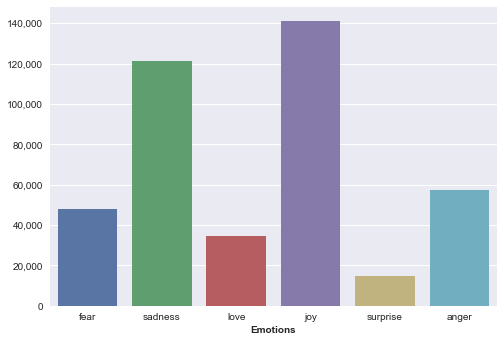

In [9]:
plt.style.use("seaborn")
plot = sns.barplot(x= list(label_distribution.keys()), y= list(label_distribution.values()))
plot.set_xlabel("Emotions",fontdict={"fontsize":10,"fontweight":"bold"});
plot.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')));
# plot.ticklabel_format(axis="y",style='plain')

### Sentence lengths

In [8]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [9]:
data['text_tok'] = [tokenizer.tokenize(sentence) for sentence in tqdm(data['text'])]
data['sent_len'] = [len(sent_tok) for sent_tok in data['text_tok']]
# data.to_csv("../data/text_tokenized.csv")

  0%|          | 0/416809 [00:00<?, ?it/s]

100%|██████████| 416809/416809 [03:15<00:00, 2128.25it/s]


Mean Length = 20.31
Max Length = 183
99% quantile = 55


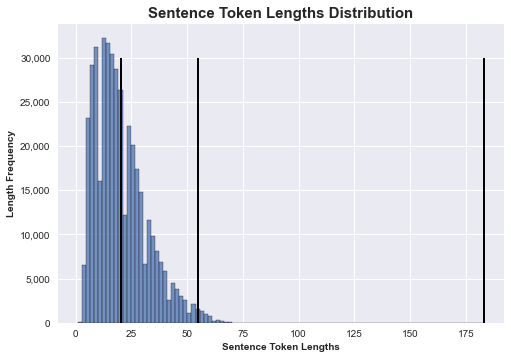

In [10]:
sent_lens_histogram = sns.histplot(data=data, x= 'sent_len', bins= 100);

sent_lens_histogram.set_xlabel("Sentence Token Lengths",fontdict={"fontsize":10,"fontweight":"bold"});
sent_lens_histogram.set_ylabel("Length Frequency", fontdict={"fontsize":10,"fontweight":"bold"});
sent_lens_histogram.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')));
sent_lens_histogram.set_title("Sentence Token Lengths Distribution", fontdict={"fontsize":15,"fontweight":"bold"})

q = 0.99
mean_len = data['sent_len'].mean()
max_len = data['sent_len'].max()
quantile_len = data['sent_len'].quantile(q)

sent_lens_histogram.vlines([mean_len, max_len, quantile_len], ymin=0, ymax=30_000,
                           linestyles='solid',linewidth=2, colors='black')
print(f"Mean Length = {mean_len:.2f}")
print(f"Max Length = {max_len:.0f}")
print(f"{q*100:.0f}% quantile = {quantile_len:.0f}")

In [11]:
data[data['sent_len'] > data['sent_len'].quantile(0.99)]

,text,label,text_tok,sent_len
24,i would imagine this is just one of the reason...,0,"[i, would, imagine, this, is, just, one, of, t...",61
226,i space on we can t blame it in order to read ...,0,"[i, space, on, we, can, t, blame, it, in, orde...",60
305,i don t want to remind him i want him to and y...,1,"[i, don, t, want, to, remind, him, i, want, hi...",58
432,i definitely feel cheated when millions of peo...,0,"[i, definitely, feel, cheated, when, millions,...",57
438,i feel more safe now especially since my psych...,1,"[i, feel, more, safe, now, especially, since, ...",60
...,...,...,...,...
416301,i feeling like a campagnol fake plastic heads ...,0,"[i, feeling, like, a, camp, ##ag, ##no, ##l, f...",58
416561,i guess ive been a little bit in denial but i ...,4,"[i, guess, iv, ##e, been, a, little, bit, in, ...",57
416638,ive used on my blog i so very wisely decided t...,1,"[iv, ##e, used, on, my, blog, i, so, very, wis...",56
416698,i like the line theyre toeing with michael fio...,2,"[i, like, the, line, they, ##re, toe, ##ing, w...",56


## Create train, test and validation splits

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X = data['text']
y = data['label']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

# 0.25 x 0.8 = 0.2
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [13]:
index_map = {v: k for k, v in emotion_map.items()}

def doit(d, order):
  return  {k: d[k] for k in sorted(order, key=order.get)}

In [14]:
labels = [emotion_map[label] for label in y_train]
label_train = doit(Counter(labels), index_map)
labels = [emotion_map[label] for label in y_test]
label_test = doit(Counter(labels), index_map)
labels = [emotion_map[label] for label in y_val]
label_val = doit(Counter(labels), index_map)
del labels

In [15]:
label_test

{'sadness': 24201,
 'joy': 28164,
 'love': 6929,
 'anger': 11441,
 'fear': 9594,
 'surprise': 3033}

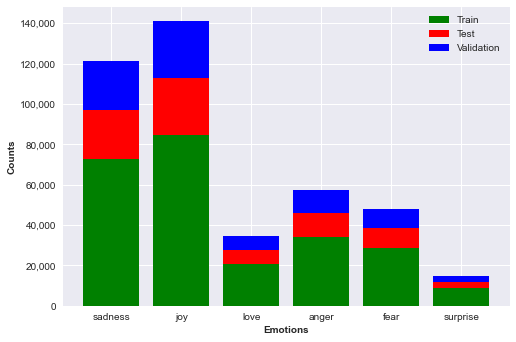

In [16]:
plt.style.use("seaborn")
fig, ax = plt.subplots()

ax.bar(list(label_train.keys()), list(label_train.values()), label="Train", color='green');
ax.bar(list(label_test.keys()), list(label_test.values()),
       bottom= list(label_train.values()), label="Test", color="red");
ax.bar(list(label_val.keys()), list(label_val.values()),
       bottom= [sum(x) for x in zip(list(label_train.values()),list(label_test.values()))],
       label="Validation", color="blue");

ax.legend(loc='best')
# plot = sns.barplot(x= list(label_train.keys()), y= list(label_train.values()),color='green',alpha=0.7)
# sns.barplot(x= list(label_train.keys()), y= list(label_train.values()),color='green',alpha=0.7)
ax.set_xlabel("Emotions",fontdict={"fontsize":10,"fontweight":"bold"});
ax.set_ylabel("Counts",fontdict={"fontsize":10,"fontweight":"bold"});
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')));

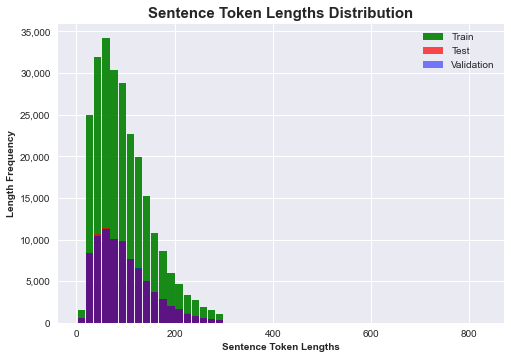

In [17]:
fig, ax = plt.subplots()

bin_height, bin_width, _ = ax.hist(x= [len(toks) for toks in X_train], bins=50, rwidth=0.9, label="Train", color="green",alpha= 0.9);
ax.hist(x= [len(toks) for toks in X_test], bins=bin_width, rwidth=0.9, label="Test", color="red",alpha= 0.7);
ax.hist(x= [len(toks) for toks in X_val], bins=bin_width, rwidth=0.9, label="Validation", color="blue", alpha= 0.5);

ax.set_xlabel("Sentence Token Lengths",fontdict={"fontsize":10,"fontweight":"bold"});
ax.set_ylabel("Length Frequency", fontdict={"fontsize":10,"fontweight":"bold"});
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')));
ax.set_title("Sentence Token Lengths Distribution", fontdict={"fontsize":15,"fontweight":"bold"});

ax.legend(loc='best');

### Save data

In [19]:
# X_train.to_csv("../data/train/X.csv")
# X_test.to_csv("../data/test/X.csv")
# X_val.to_csv("../data/val/X.csv")
# y_train.to_csv("../data/train/Y.csv")
# y_test.to_csv("../data/test/Y.csv")
# y_val.to_csv("../data/val/Y.csv")

# Class Weights Balance


In [18]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))

In [19]:
class_weights

{0: 0.5730663293598962,
 1: 0.4920821379801581,
 2: 2.0206929429065466,
 3: 1.2151846452866861,
 4: 1.4487099278208382,
 5: 4.656556064499311}